In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [240]:
df = pd.read_excel('proteins.xlsx')

In [241]:
# first we load the xlsx file with the information of the types of meals, proteins and calories.
df.head()

,meals,proteins,calories
0,chicken,32.8,148
1,beef,26.4,163
2,cheese,26.0,316
3,fish,19.2,109
4,egg,13.0,149


In [242]:
df.shape

(25, 3)

In [243]:
# restrictions of the population
weight = 90
max_cal = 33*weight # maximum amount of daily calories per individual
max_pro = 2.5*weight # maximum amount of daily proteins per individual

In [244]:
cromos = list()  # valid chromosomes given the setted restrictions    
while len(cromos)<10:
    j = list(np.random.choice(2,25))  # random creation of the population
    if sum(j*df.proteins) < max_pro and sum(j*df.calories) < max_cal:
        cromos.append(j)

In [245]:
# first set of individuals of the population
cromos

[[1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1],
 [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
 [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
 [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1],
 [1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0],
 [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
 [1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1],
 [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]]

In [246]:
# fit function to calculate the fitness of each individual of the population
def fitness(cromos): 
    fits = list()
    for i in cromos:
        fits.append(sum(i*df.proteins))
    return fits        

In [247]:
# fit of each chromosome of the first population
fitness(cromos)

[131.89999999999998,
 181.09999999999997,
 90.56,
 132.4,
 176.25999999999996,
 157.25999999999996,
 124.96,
 123.06,
 146.36,
 84.1]

In [248]:
# fuction to create the probability pie of selecting each chromosome given its fit
def proba(cromos):
    proba = list()
    for i in cromos:
        proba.append(2*np.pi*sum(i*df.proteins)/sum([sum(j*df.proteins) for j in cromos])) # proportion of fitness over the total 
    proba = np.asarray(proba)
    proba = proba.cumsum()
    return proba

In [249]:
# function of roulette wheel selection of parents
def proge(cromos):
    parents = list()
    while len(parents)<2: # seleccionamos 2 padres, sin que sean iguales
        k=0
        flecha = np.random.random()*2*np.pi
        for j in proba(cromos):
            if flecha < j and k<1:
                padre = cromos[list(proba(cromos)).index(j)]
                if len(parents)==0:
                        parents.append(padre)
                        k+=1
                elif len(parents)==1:
                    if padre!=parents[0]:
                        parents.append(padre)
                        k+=1
                    else:
                        k+=1
                else:
                    k+=1
    return parents

In [250]:
# function to create two new individuals by binary crossover of two previously selected parents
def cross(parent1,parent2):
    childs = list()
    while len(childs)<2:
        corte = np.random.randint(len(parents[0]))
        child1 = parent1[:corte] + parent2[corte:]
        child2 = parent2[:corte] + parent1[corte:]
        if (sum(child1*df.proteins) < max_pro and sum(child1*df.calories) < max_cal) and (sum(child2*df.proteins) < max_pro and sum(child2*df.calories) < max_cal):
            childs.append(child1)
            childs.append(child2)
    return childs

In [251]:
# function to mutate the new born childs using random SWAP of two genes, setting a probability of a child being mutated of 10%

def mutant(child):
    i1 = np.random.randint(25)
    i2 = np.random.randint(25)
    value1 = child[i1]
    value2 = child[i2]
    child[i1] = value2
    child[i2] = value1
    if sum(child*df.proteins) < max_pro and sum(child*df.calories) < max_cal and np.random.random()<0.10:
        return child        
    else:
        value1 = child[i1]
        value2 = child[i2]
        child[i1] = value2
        child[i2] = value1
        return child

In [252]:
# function to replace two individuals of the original population by the two childs created, taking into account its genetic similarity (euclidian distance og chromosomes) 
def replace(childs):    
    for i in childs: # deleting two individuals 
        dist = list()
        for j in cromos:
            dist.append(distance.euclidean(j,i))
        cromos.pop(np.asarray(dist).argmin())
    for i in childs:
        cromos.append(i)        
    return cromos

In [253]:
# function of the set of meals that maximize the amount of protein
# given the restrictions of maximum amount of proteins and calories an athlete can consume per day
def meal(crom):
    meals = list()
    for i in df.meals:
        for c in crom:
            if c==1:
                meals.append(i)
    return set(meals)

In [254]:
# function of the amount of calories of the best set of meals
def calories(crom):
    return sum(crom*df.calories)

In [255]:
best_fits = list()
cromis = list()
for i in range(1000):
    fits = fitness(cromos)
    best_fits.append(max(fits))
    cromis.append(cromos[fits.index(max(fits))])
    parents = proge(cromos)
    parent1 = parents[0]
    parent2 = parents[1]
    childs = cross(parent1,parent2)
    child1 = childs[0]
    child2 = childs[1]
    new_childs=list()
    new_childs.append(mutant(child1))
    new_childs.append(mutant(child2))
    cromos = replace(new_childs)
best_fit = (max(best_fits))
crom = cromis[best_fits.index(best_fit)]
print('Iteration Nr.: ',best_fits.index(best_fit))
print('Max. Proteins: ', "{:.2f}".format(best_fit))
print('Calories: ',"{:.2f}".format(calories(crom)))
print('Chromosome: ', crom)  
print('Best Diet: ',meal(crom))

Iteration Nr.:  154
Max. Proteins:  215.50
Calories:  2925.00
Chromosome:  [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
Best Diet:  {'kefir', 'almonds', 'watermelon', 'beans', 'orange', 'potatoe', 'peanut', 'pistacchio', 'rice', 'beef', 'egg', 'fish', 'carrot', 'apple', 'chicken', 'yogurt', 'walnuts', 'banana', 'lentils', 'chickpea', 'lettuce', 'tomatoe', 'cheese', 'tofu', 'milk'}


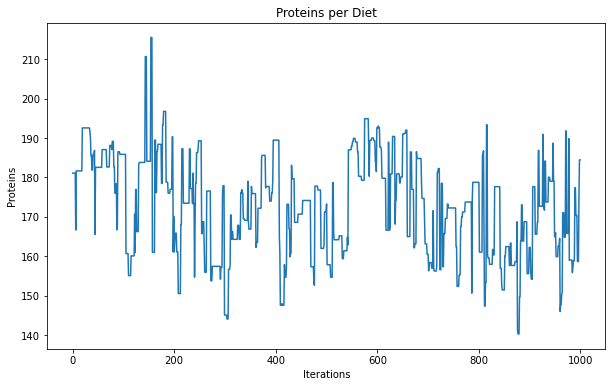

In [256]:
plt.figure(figsize=(10,6))
plt.xlabel('Iterations')
plt.ylabel('Proteins')
plt.title('Proteins per Diet')
plt.plot(best_fits) # graphic with the best fits for each iteration.